In [247]:
##!pip install mlxtend
##!pip install onnxmltools
##!pip install onnxruntime

##!pip install torch torchvision torchaudio
##!pip install onnx onnxruntime
##!pip install numpy pillow
##!pip install xgboost
##!pip install onnxmltools
##!pip install onnxconverter_common
##!pip install skl2onnx




In [250]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random
import onnxconverter_common
import skl2onnx


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [251]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score

In [252]:
import xgboost as xgb


In [253]:
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

In [254]:
## 0.001, 0.0001, 0.0003, 0.01, 0.03

batch_size    = 16
learning_rate = 0.005 ## 0.001
N_Epochs      = 100

epsilon = 0.0001

In [255]:
import pandas as pd

# Specify the corrected file path using forward slashes or double backslashes
path_data = "C:/Users/Conno/Dropbox/SocialAds/social_ads.csv"
# Alternatively, use double backslashes for Windows paths:
# path_data = "C:\\Users\\Conno\\Dropbox\\SocialAds\\social_ads.csv"

# Read the CSV file into a DataFrame
ADS_raw_data = pd.read_csv(path_data, delimiter=";")


In [256]:
ADS_raw_data


,"Age,Salary,Purchased"
0,"19,19000,0"
1,"35,20000,0"
2,"26,43000,0"
3,"27,57000,0"
4,"19,76000,0"
...,...
395,"46,41000,1"
396,"51,23000,1"
397,"50,20000,1"
398,"36,33000,0"


In [257]:
headers_list = ADS_raw_data.columns.values.tolist()

headers_list

['Age,Salary,Purchased']

In [258]:
headers_list2 = [ 'Age',
 'Salary',
 'Purchased']

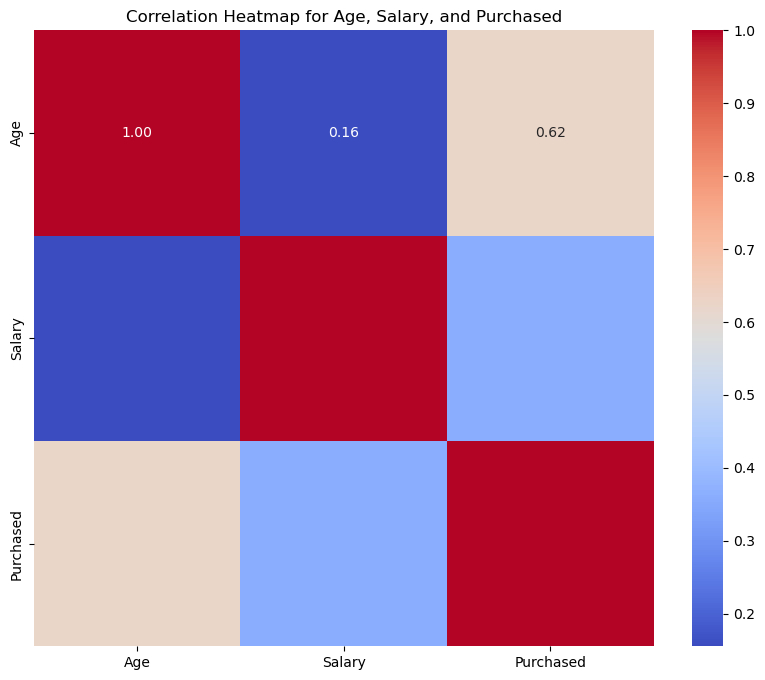

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your Ads data from the CSV file
# Replace 'path_to_your_file.csv' with the actual path to your CSV file
path_data = "C:/Users/Conno/Dropbox/SocialAds/social_ads.csv"

ADS_raw_data = pd.read_csv(path_data)

# Select columns of interest for correlation analysis
columns_of_interest = ['Age', 'Salary', 'Purchased']

# Convert 'purchased' column to numeric (assuming it's already 0/1)
ADS_raw_data['Purchased'] = pd.to_numeric(ADS_raw_data['Purchased'], errors='coerce')

# Calculate correlation coefficients
cm = np.corrcoef(ADS_raw_data[columns_of_interest].values.T)

# Create heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=columns_of_interest, yticklabels=columns_of_interest)
plt.title("Correlation Heatmap for Age, Salary, and Purchased")
plt.show()



In [260]:
## Convert Pandas to Numpy

ADS_raw_data_np = ADS_raw_data.to_numpy()

In [261]:
ADS_raw_data_np


array([[   19, 19000,     0],
       [   35, 20000,     0],
       [   26, 43000,     0],
       ...,
       [   50, 20000,     1],
       [   36, 33000,     0],
       [   49, 36000,     1]], dtype=int64)

In [262]:
ADS_raw_data_np.shape


(400, 3)

In [263]:
X = ADS_raw_data_np[:, :-1]


y = ADS_raw_data_np[:, 11:12]

In [264]:
y


array([], shape=(400, 0), dtype=int64)

In [265]:
print(X.shape)

print(y.shape)

(400, 2)
(400, 0)


In [266]:
random_seed = int( random.random() * 100 )     ## 42


In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [268]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 2)
(80, 2)
(320, 0)
(80, 0)


In [269]:
y_test.dtype 


dtype('int64')

In [270]:
## fix data type

X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.float32  )
y_test  = y_test.astype(   np.float32  )

In [271]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

In [272]:
x_means      = X_train_tr.mean(0, keepdim=True ) 

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [273]:
x_means


tensor([[3.8078e+01, 6.8416e+04]])

In [274]:
x_deviations


tensor([[1.0354e+01, 3.3570e+04]])

In [275]:
train_ds = TensorDataset( X_train_tr, y_train_tr  )


In [276]:
train_dl = DataLoader( train_ds, batch_size, shuffle=True  )


In [277]:
train_dl


In [278]:
## Linear Regression

class LinRegNet(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 1)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        y_pred = self.linear1(x)
        ## return torch.round( y_pred )
        return y_pred
        

In [279]:
## MLP

class MLP_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 8)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [280]:
## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 10)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [281]:
## Linear plus Nonlinear
## f1 + f2

class LinearPlusNonLinear_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(11, 1)
        
        ## F2
        self.f2_linear1 = nn.Linear(11, 14)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
        
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        
        y_pred = f1 + f2
        
        ## return torch.round( y_pred )
        return y_pred

In [282]:
def training_loop( N_Epochs, model, loss_fn, opt  ):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 20 == 0:
            print(epoch, "loss=", loss)
            

In [283]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = x_means
        self.x_deviations = x_deviations
        self.linear1 = nn.Linear(len(x_means), 64)
        self.linear2 = nn.Linear(64, 1)
        self.act1 = nn.ReLU()

    def forward(self, x):
        # Ensure x_means and x_deviations are tensors
        x_means_tensor = torch.tensor(self.x_means, dtype=torch.float32)
        x_deviations_tensor = torch.tensor(self.x_deviations, dtype=torch.float32)
        
        # Normalize input x
        x_normalized = (x - x_means_tensor) / x_deviations_tensor
        
        # Apply linear -> activation -> linear
        x = self.linear1(x_normalized)
        x = self.act1(x)
        x = self.linear2(x)
        return torch.sigmoid(x)  # Apply sigmoid for binary classification


In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = x_means
        self.x_deviations = x_deviations
        self.linear1 = nn.Linear(len(x_means), 64)
        self.linear2 = nn.Linear(64, 1)
        self.act1 = nn.ReLU()

    def forward(self, x):
        # Ensure x_means and x_deviations are tensors
        x_means_tensor = torch.tensor(self.x_means, dtype=torch.float32)
        x_deviations_tensor = torch.tensor(self.x_deviations, dtype=torch.float32)

        print("x shape:", x.shape)
        print("x_means shape:", x_means_tensor.shape)
        print("x_deviations shape:", x_deviations_tensor.shape)
        
        # Normalize input x
        x_normalized = (x - x_means_tensor) / x_deviations_tensor
        
        print("x_normalized shape:", x_normalized.shape)
        
        # Apply linear -> activation -> linear
        x = self.linear1(x_normalized)
        x = self.act1(x)
        x = self.linear2(x)
        return torch.sigmoid(x)  # Apply sigmoid for binary classification


In [285]:
class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = nn.Parameter(x_means)  # Assuming x_means is a tensor
        self.x_deviations = nn.Parameter(x_deviations)  # Assuming x_deviations is a tensor
        self.linear1 = nn.Linear(in_features, hidden_size)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, out_features)
    
    def forward(self, x):
        print("Shape of x:", x.shape)
        print("Shape of self.x_means:", self.x_means.shape)
        print("Shape of self.x_deviations:", self.x_deviations.shape)
        
        # Check if shapes match for element-wise operations
        assert x.shape == self.x_means.shape == self.x_deviations.shape, "Shape mismatch"
        
        # Perform normalization and forward pass
        x_normalized = (x - self.x_means) / self.x_deviations
        x = self.act1(self.linear1(x_normalized))
        x = self.linear2(x)
        
        return x



In [286]:
## y_pred_test


In [287]:
import torch.nn as nn
import torch.nn.functional as F

class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = nn.Parameter(torch.tensor(x_means), requires_grad=False)
        self.x_deviations = nn.Parameter(torch.tensor(x_deviations), requires_grad=False)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Normalize input using x_means and x_deviations
        x = (x - self.x_means) / self.x_deviations
        x = self.act1(self.linear1(x))
        x = self.linear2(x)
        return x



In [288]:
class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = nn.Parameter(torch.tensor(x_means))
        self.x_deviations = nn.Parameter(torch.tensor(x_deviations))
        # Define your model layers here

    def forward(self, x):
        # Normalize input tensor 'x' using x_means and x_deviations
        normalized_x = (x - self.x_means) / self.x_deviations
        # Pass through model layers
        # Example: normalized_x = self.conv1(normalized_x)
        #          normalized_x = self.relu(normalized_x)
        return normalized_x



In [289]:
y_test_tr.shape


torch.Size([80, 0])

In [290]:
len(X_test_tr)


80

In [291]:
class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = torch.tensor(x_means)  # Assuming x_means is a numpy array or list
        self.x_deviations = torch.tensor(x_deviations)  # Assuming x_deviations is a numpy array or list
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        print("Input shape:", x.shape)
        print("Means shape:", self.x_means.shape)
        print("Deviations shape:", self.x_deviations.shape)
        
        x = (x - self.x_means) / self.x_deviations  # Check shapes and types here
        print("Transformed input shape:", x.shape)
        
        x = self.act1(self.linear1(x))
        x = self.linear2(x)
        return x



In [292]:
class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super(DL_Net, self).__init__()
        self.x_means = torch.tensor(x_means)
        self.x_deviations = torch.tensor(x_deviations)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        print("Input shape:", x.shape)
        print("Means shape:", self.x_means.shape)
        print("Deviations shape:", self.x_deviations.shape)

        x = (x - self.x_means) / self.x_deviations  # Check shapes and types here
        print("Transformed input shape:", x.shape)

        x = self.act1(self.linear1(x))
        x = self.linear2(x)
        return x


In [293]:
regressor = xgb.XGBRegressor(

        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=3
)

In [294]:
import xgboost as xgb

# Assuming X_train and y_train are properly defined
# X_train should be a 2D array (samples x features)
# y_train should be a 1D array (labels)

# Print shapes of X_train and y_train
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Create an instance of XGBRegressor
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

# Fit the regressor to the training data
try:
    regressor.fit(X_train, y_train)
    print("Model training successful!")
except Exception as e:
    print("Error during training:", e)




X_train shape: (320, 2)
y_train shape: (320, 0)
Error during training: [23:54:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:48: Check failed: info.labels.Size() == preds.Size() (0 vs. 320) : Invalid shape of labels.


In [295]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load data from CSV file
data = pd.read_csv('C:/Users/Conno/Dropbox/SocialAds/social_ads.csv')

# Display basic information about the data
print("Shape of data:", data.shape)
print("Columns of data:", data.columns)

# Assuming 'Purchased' is the target column
target_column_name = 'Purchased'

# Separate features (X) and target variable (y)
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

# Check for and handle missing values
print("NaN values in X:", X.isnull().sum().any())
print("NaN values in y:", y.isnull().sum().any())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of XGBRegressor
regressor = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Evaluate the model (e.g., using RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)


Shape of data: (400, 3)
Columns of data: Index(['Age', 'Salary', 'Purchased'], dtype='object')
NaN values in X: False
NaN values in y: False
Root Mean Squared Error: 0.3127700408045913


In [296]:
y_pred.shape


(80,)

In [297]:
y_pred


array([ 0.9788181 ,  1.0722193 , -0.01612116,  0.6916023 ,  0.00269255,
       -0.00364683,  0.9297528 , -0.04941066,  0.17307119, -0.05790855,
       -0.06412283,  1.0540602 , -0.04901338,  0.00269255,  0.10731786,
        0.9942297 ,  0.6938482 ,  0.3698316 ,  0.01365973,  0.90472746,
        0.00269255,  0.041746  ,  0.9713406 ,  0.2040061 ,  0.00269255,
        0.6652461 ,  0.37050566,  0.04806327,  1.0379676 ,  0.00269255,
        0.5294752 ,  0.5723103 ,  0.9568511 ,  0.11018369,  1.0043905 ,
        0.02883751,  0.04806327, -0.10905139,  0.00269255,  0.00910813,
        0.99111354, -0.00802351, -0.00802351,  0.9713406 ,  0.04808855,
        0.6999848 ,  0.00196839,  0.05515093,  0.56463146, -0.01154778,
        0.11018369,  0.5426277 , -0.05320102,  0.041746  ,  0.1707659 ,
        0.00269255,  1.0148808 ,  1.0309137 , -0.00744616,  0.01304145,
        0.18484534, -0.00827249,  0.62935805,  0.10615599, -0.00802351,
        1.0251864 ,  0.49506772,  0.8921049 ,  0.00698317,  0.83

In [298]:
r2_score(y_test, y_pred)


0.5699995673630518

In [299]:
initial_types = [(
          'float_input',
          FloatTensorType(  [None, 11 ]  )

)]

In [301]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import onnxmltools
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

# Load data from CSV file
data = pd.read_csv('C:/Users/Conno/Dropbox/SocialAds/social_ads.csv')

# Assuming 'Purchased' is the target column
target_column_name = 'Purchased'

# Separate features (X) and target variable (y)
X = data.drop(columns=[target_column_name])
y = data[target_column_name]

# Rename columns to match 'f%d' pattern for ONNX compatibility
X.columns = ['f{}'.format(i) for i in range(len(X.columns))]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of XGBRegressor
regressor = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Evaluate the model (e.g., using RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Specify the initial types for input data (X_test)
initial_type = [('float_input', FloatTensorType([None, X_test.shape[1]]))]

# Convert XGBoost model to ONNX format
onnx_model = convert_xgboost(regressor, initial_types=initial_type)

# Save the ONNX model to a file
onnxmltools.utils.save_model(onnx_model, 'xgboost_AdsQuality_ort.onnx')


Root Mean Squared Error: 0.3127700408045913


In [302]:
sess = rt.InferenceSession('xgboost_AdsQuality_ort.onnx')


In [303]:
input_name = sess.get_inputs()[0].name


In [304]:
input_name


'float_input'

In [305]:
label_name = sess.get_outputs()[0].name


In [306]:
label_name


'variable'

In [308]:
import numpy as np
import onnxruntime as ort

# Assuming you have already loaded the ONNX model and defined 'sess' and 'input_name' variables

# Convert the input data to the correct format (list of dictionaries)
input_data = {input_name: X_test.values.astype(np.float32)}

# Run inference using the ONNX runtime session
pred_ort = sess.run([], input_data)


In [309]:
pred_ort[0]


array([[ 0.97881824],
       [ 1.0722198 ],
       [-0.01612118],
       [ 0.69160265],
       [ 0.00269258],
       [-0.00364685],
       [ 0.92975307],
       [-0.04941067],
       [ 0.17307116],
       [-0.05790854],
       [-0.06412286],
       [ 1.0540606 ],
       [-0.04901338],
       [ 0.00269258],
       [ 0.10731781],
       [ 0.99423003],
       [ 0.69384825],
       [ 0.36983162],
       [ 0.01365972],
       [ 0.9047274 ],
       [ 0.00269258],
       [ 0.04174599],
       [ 0.97134066],
       [ 0.20400605],
       [ 0.00269258],
       [ 0.66524625],
       [ 0.37050563],
       [ 0.04806331],
       [ 1.0379674 ],
       [ 0.00269258],
       [ 0.5294752 ],
       [ 0.5723105 ],
       [ 0.9568512 ],
       [ 0.11018369],
       [ 1.0043905 ],
       [ 0.0288375 ],
       [ 0.04806331],
       [-0.10905135],
       [ 0.00269258],
       [ 0.0091081 ],
       [ 0.99111396],
       [-0.00802353],
       [-0.00802353],
       [ 0.97134066],
       [ 0.04808855],
       [ 0